In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from pprint import pprint

In [3]:
import sys
sys.path.append("..")

In [4]:
from pymatgen.core.structure import Structure, IStructure

In [5]:
from digitalbeamline.extern.m3gnet._featurizer import featurize_material
from digitalbeamline.extern.m3gnet.m3gnet4xas import GRIDS
from digitalbeamline.extern.lightshow import prepare_dataset, save_dataset
from digitalbeamline.utils import set_plotting_defaults

In [6]:
set_plotting_defaults()

# Load, process and split the data for ML

Note currently we're assuming these are oxide databases. So stuff like `X-O`, where `X` is a transition metal.

In [7]:
ELEMENT = "Ti"

For every structure-site pair in the FEFF data, we triple check that it matches up perfectly to the POSCAR file in the VASP data. This is a quick sanity check since in the past there has been some minor [edge case issues](https://github.com/AI-multimodal/Lightshow/issues/199) with the site-matching.

In [8]:
ROUNDING_PRECISON = 6

def read_FEFF_geometry(path):
    path = Path(path) / "feff.inp"

    with open(path, "r") as f:
        feff_lines = f.readlines()
    where_atoms = [
        ii for ii, xx in enumerate(feff_lines) if xx.startswith("ATOMS")
    ]
    assert len(where_atoms) == 1
    feff_lines = feff_lines[where_atoms[0] + 3 : -1]
    feff_lines = [xx.split() for xx in feff_lines]

    atoms = [xx[4] for xx in feff_lines]

    distances = [float(xx[5]) for xx in feff_lines]

    # All together
    # 6 is the default precision used in FEFF by PMG!!!
    tmp = [
        [round(distance, ROUNDING_PRECISON), atom]
        for atom, distance in zip(atoms, distances)
    ]
    tmp.sort(key=lambda xx: xx[0])

    return {
        "atoms": [xx[1] for xx in tmp[1:]],
        "distances": np.array([xx[0] for xx in tmp[1:]]),
    }


def read_VASP_geometry(path, neighbor_radius=10.0):
    path = Path(path) / "POSCAR"

    # VASP POSCAR files are easy, only need data after line 8
    structure = IStructure.from_file(path)
    # vasp_coordinates = np.array([site.frac_coords for site in vasp_structure])
    # vasp_atoms = [site.specie.symbol for site in vasp_structure]

    neigh = structure.get_neighbors(structure[0], r=neighbor_radius)
    tmp = [
        [round(xx.nn_distance, ROUNDING_PRECISON), str(xx.specie)]
        for xx in neigh
    ]
    tmp.sort(key=lambda xx: xx[0])

    return {
        "atoms": [xx[1] for xx in tmp],
        "distances": np.array([xx[0] for xx in tmp]),
    }

- `good_vasp_paths` match correctly with their FEFF site
- `bad_vasp_paths` do not match correctly with their FEFF site
- Note that some FEFF sites do not have a corresponding VASP site, those make it to neither list

In [16]:
good_vasp_paths = []
bad_vasp_paths = []
geometries = {}

for mpid in tqdm(Path(f"data/data_feff/{ELEMENT}").iterdir()):

    if not mpid.is_dir():
        continue

    for site in (mpid / "FEFF-XANES").iterdir():

        site_index, site_species = str(site.name).split("_")
        site_index = int(site_index)
        assert site_species == ELEMENT, site

        feff_geometry_info = read_FEFF_geometry(site)

        vasp_path = Path(f"data/data_vasp/{ELEMENT}/{mpid.name}/VASP/{site.name}")

        try:
            vasp_geometry_info = read_VASP_geometry(vasp_path)
        except FileNotFoundError:
            continue
        
        if not vasp_path.exists():
            continue

        key = f"{mpid.name}_{site.name}"
        geometries[key] = {
            "feff": feff_geometry_info["distances"][:10],
            "vasp": vasp_geometry_info["distances"][:10],
            "valid": True
        }
        
        if not np.allclose(geometries[key]["feff"], geometries[key]["vasp"], atol=1e-4, rtol=1e-5):
            bad_vasp_paths.append(vasp_path)
            geometries[key]["valid"] = False
            
            continue

        good_vasp_paths.append(vasp_path)

2781it [00:16, 170.85it/s]


In [17]:
print(len(good_vasp_paths))
print(len(bad_vasp_paths))

3259
8


In [27]:
print("--- ALL BAD GEOMETRIES ---")
bad_geometries = {key: value for key, value in geometries.items() if not value["valid"]}
for key, value in bad_geometries.items():
    print(key)
    feff = np.round(value["feff"], 3)
    vasp = np.round(value["vasp"], 3)
    print(f"\tFEFF {feff}")
    print(f"\tVASP {vasp}")

--- ALL BAD GEOMETRIES ---
mp-1176604_012_Ti
	FEFF [1.971 1.971 2.145 2.145 2.148 2.148 3.073 3.073 3.207 3.207]
	VASP [1.975 1.975 2.147 2.147 2.147 2.147 3.    3.    3.215 3.215]
mp-1315810_011_Ti
	FEFF [1.993 1.997 2.03  2.037 2.038 2.104 2.921 2.932 2.957 2.959]
	VASP [2.012 2.018 2.019 2.029 2.066 2.067 2.951 2.954 2.956 2.957]
mp-1221952_008_Ti
	FEFF [1.874 1.875 1.877 2.125 2.125 2.125 2.942 3.008 3.009 3.009]
	VASP [1.875 1.875 1.875 2.134 2.136 2.136 2.91  3.009 3.009 3.009]
mp-1208356_002_Ti
	FEFF [1.831 1.831 1.941 1.946 2.249 2.249 3.327 3.348 3.527 3.527]
	VASP [1.788 1.905 1.905 2.184 2.211 2.211 3.196 3.434 3.434 3.674]
mp-763993_006_Ti
	FEFF [2.001 2.001 2.01  2.013 2.07  2.072 2.926 2.946 2.952 2.994]
	VASP [1.995 1.995 2.05  2.051 2.051 2.051 2.971 2.971 2.986 2.986]
mp-1276363_009_Ti
	FEFF [1.93  1.943 2.008 2.03  2.037 2.061 3.393 3.402 3.431 3.454]
	VASP [1.999 1.999 2.005 2.005 2.02  2.02  3.39  3.391 3.448 3.449]
mp-1218859_008_Ti
	FEFF [1.97  1.97  1.97  1.97  1

In [28]:
print("--- SOME GOOD GEOMETRIES ---")
good_geometries = {key: value for key, value in geometries.items() if value["valid"]}
cc = 0
for key, value in good_geometries.items():
    print(key)
    feff = np.round(value["feff"], 3)
    vasp = np.round(value["vasp"], 3)
    print(f"\tFEFF {feff}")
    print(f"\tVASP {vasp}")
    cc += 1
    if cc == 8:
        break

--- SOME GOOD GEOMETRIES ---
mvc-16746_002_Ti
	FEFF [2.021 2.021 2.021 2.021 2.037 2.037 2.982 2.982 2.982 2.982]
	VASP [2.021 2.021 2.021 2.021 2.037 2.037 2.982 2.982 2.982 2.982]
mvc-16746_003_Ti
	FEFF [2.073 2.073 2.136 2.136 2.136 2.136 2.964 2.964 2.982 2.982]
	VASP [2.073 2.073 2.136 2.136 2.136 2.136 2.964 2.964 2.982 2.982]
mp-1223106_002_Ti
	FEFF [1.863 1.981 1.981 1.99  1.99  2.184 3.091 3.091 3.401 3.401]
	VASP [1.863 1.981 1.981 1.99  1.99  2.184 3.091 3.091 3.401 3.401]
mp-1223106_004_Ti
	FEFF [1.935 1.935 1.951 1.951 1.951 1.951 3.486 3.486 3.486 3.486]
	VASP [1.935 1.935 1.951 1.951 1.951 1.951 3.486 3.486 3.486 3.486]
mp-778984_022_Ti
	FEFF [1.928 1.952 1.967 2.033 2.165 2.174 3.043 3.044 3.057 3.074]
	VASP [1.928 1.952 1.967 2.033 2.165 2.174 3.043 3.044 3.057 3.074]
mp-778984_016_Ti
	FEFF [1.879 1.907 1.923 2.02  2.161 2.187 3.044 3.135 3.145 3.253]
	VASP [1.879 1.907 1.923 2.02  2.161 2.187 3.044 3.135 3.145 3.253]
mp-778984_012_Ti
	FEFF [1.872 1.899 1.918 2.045 2.1

In [341]:
purge_structures = set([xx.parts[-3] for xx in bad_vasp_paths])

In [351]:
grid = GRIDS["VASP"]["Ti"]

In [352]:
data = prepare_dataset(
    f"data/data_vasp/{ELEMENT}", 
    grid,
    featurize_material,
    ELEMENT,
    spectra_type="VASP",
    purge_structures=purge_structures,
    broadening=0.59
)

Loading structures and spectra...


  5%|██▏                                      | 75/1406 [00:04<01:37, 13.65it/s]/Users/mc/GitHub/Crescendo/crescendo/extern/lightshow/_lightshow.py:110: UserWarning: loadtxt: input contained no data: "data/data_vasp/Ti/mp-1177850/VASP/SCF/scfenergy.txt"
  e_scf = np.loadtxt(scf).item()
 15%|█████▊                                  | 206/1406 [00:15<00:59, 20.30it/s]

Purging mp-1176604


 21%|████████▍                               | 297/1406 [00:21<00:59, 18.76it/s]/Users/mc/GitHub/Crescendo/crescendo/extern/lightshow/_lightshow.py:110: UserWarning: loadtxt: input contained no data: "data/data_vasp/Ti/mp-758259/VASP/SCF/scfenergy.txt"
  e_scf = np.loadtxt(scf).item()
 27%|██████████▊                             | 381/1406 [00:27<00:39, 25.65it/s]

Purging mp-1315810


 29%|███████████▍                            | 401/1406 [00:28<00:44, 22.40it/s]/Users/mc/GitHub/Crescendo/crescendo/extern/lightshow/_lightshow.py:110: UserWarning: loadtxt: input contained no data: "data/data_vasp/Ti/mp-1208225/VASP/SCF/scfenergy.txt"
  e_scf = np.loadtxt(scf).item()
 33%|█████████████▏                          | 465/1406 [00:32<01:56,  8.09it/s]

Purging mp-1221952


 38%|███████████████▎                        | 537/1406 [00:36<00:38, 22.65it/s]

Purging mp-1208356


 42%|████████████████▋                       | 587/1406 [00:40<00:57, 14.24it/s]/Users/mc/GitHub/Crescendo/crescendo/extern/lightshow/_lightshow.py:110: UserWarning: loadtxt: input contained no data: "data/data_vasp/Ti/mp-752651/VASP/SCF/scfenergy.txt"
  e_scf = np.loadtxt(scf).item()
 49%|███████████████████▌                    | 687/1406 [00:48<00:37, 19.02it/s]/Users/mc/GitHub/Crescendo/crescendo/extern/lightshow/_lightshow.py:110: UserWarning: loadtxt: input contained no data: "data/data_vasp/Ti/mp-1217194/VASP/SCF/scfenergy.txt"
  e_scf = np.loadtxt(scf).item()
 51%|████████████████████▌                   | 724/1406 [00:50<00:25, 26.42it/s]

Purging mp-763993


 57%|██████████████████████▋                 | 797/1406 [00:53<00:23, 25.82it/s]

Purging mp-1276363


 58%|███████████████████████                 | 811/1406 [00:55<00:35, 16.78it/s]/Users/mc/GitHub/Crescendo/crescendo/extern/lightshow/_lightshow.py:110: UserWarning: loadtxt: input contained no data: "data/data_vasp/Ti/mp-754528/VASP/SCF/scfenergy.txt"
  e_scf = np.loadtxt(scf).item()
 73%|████████████████████████████▍          | 1023/1406 [01:12<00:16, 22.93it/s]

Purging mp-1218859


 76%|█████████████████████████████▌         | 1068/1406 [01:15<00:20, 16.72it/s]/Users/mc/GitHub/Crescendo/crescendo/extern/lightshow/_lightshow.py:110: UserWarning: loadtxt: input contained no data: "data/data_vasp/Ti/mp-755965/VASP/SCF/scfenergy.txt"
  e_scf = np.loadtxt(scf).item()
 82%|███████████████████████████████▊       | 1146/1406 [01:18<00:10, 25.61it/s]/Users/mc/GitHub/Crescendo/crescendo/extern/lightshow/_lightshow.py:110: UserWarning: loadtxt: input contained no data: "data/data_vasp/Ti/mp-1101349/VASP/SCF/scfenergy.txt"
  e_scf = np.loadtxt(scf).item()
 92%|███████████████████████████████████▉   | 1295/1406 [01:26<00:04, 25.19it/s]

Purging mp-1177884


100%|███████████████████████████████████████| 1406/1406 [01:31<00:00, 15.28it/s]


Interpolating spectra...
Double checking indexes...
Converting to arrays...


100%|███████████████████████████████████████| 3928/3928 [05:05<00:00, 12.87it/s]


Done


In [353]:
for ii, spectrum in enumerate(data["spectra"]):
    # s2 = broadGaussFast(grid, spectrum, 0.59)
    m = spectrum[150:].mean()
    # m = 1.0
    data["spectra"][ii] = spectrum / m

In [354]:
len(data["spectra"])

3928

# Plot sanity check

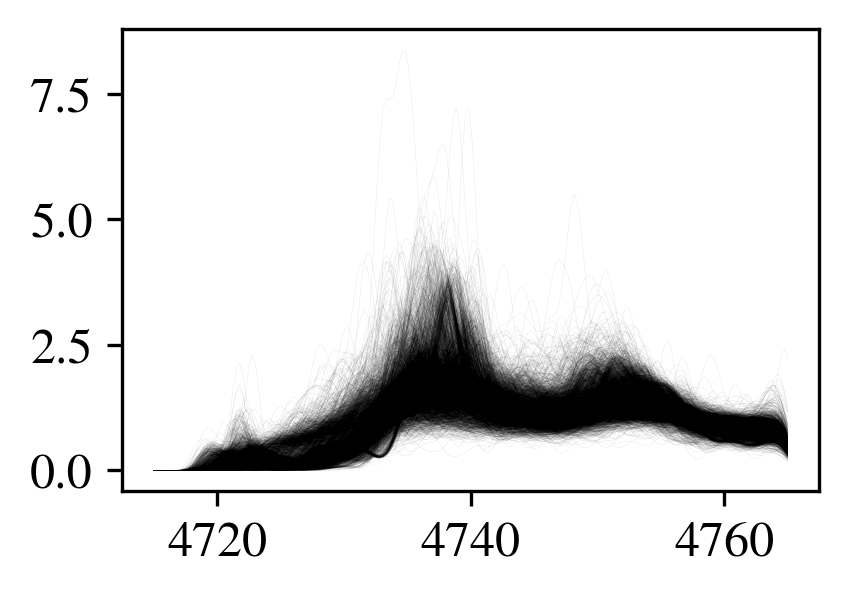

In [355]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))

for s in data["spectra"]:
    ax.plot(grid, s, color="black", alpha=0.1, linewidth=0.1)
plt.show()

# PCA sanity check

In [356]:
from sklearn.decomposition import PCA

In [357]:
pca = PCA(1)
w = pca.fit_transform(data["node_features"])

In [362]:
pca_spectra = PCA(2)
d = data["spectra"].copy()
# d = (d - d.mean(axis=0)) / (1e-8 + d.std(axis=0))
w_spectra = pca_spectra.fit_transform(d)

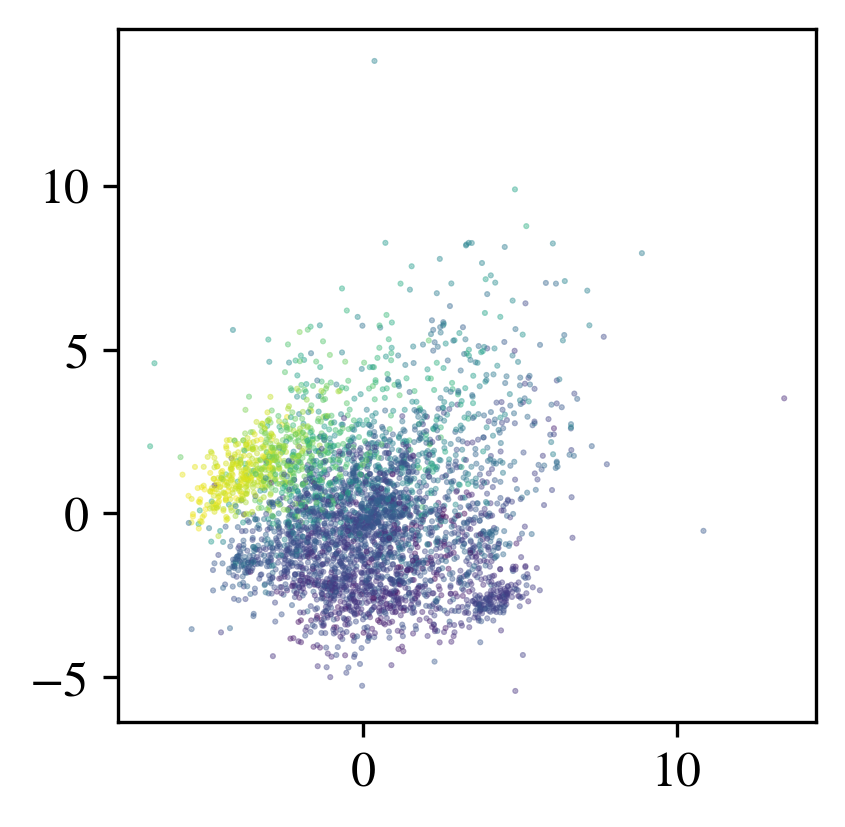

In [364]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.scatter(w_spectra[:, 0], w_spectra[:, 1], alpha=0.5, s=0.2, c=w)
# plt.xlim(-10, 10)
plt.show()

# Save the data

The `"random"` split method partitions into training, validation and testing splits. Some atoms from a material might be in the training and testing sets, so beware for bias here. We use this as a control regardless.

In [365]:
base_directory = Path("VASP") / Path(f"{ELEMENT}-O")
base_directory.mkdir(exist_ok=True, parents=True)

In [366]:
split_type = "random"
random_path = base_directory / f"{split_type}-splits"
random_path.mkdir(exist_ok=True, parents=True)

In [367]:
save_dataset(random_path, data, train_prop=0.8, split_type=split_type, random_state=42)

Random split...
Train    X=(3142, 64), Y=(3142, 200)
Val      X=(393, 64), Y=(393, 200)
Test     X=(393, 64), Y=(393, 200)


The `"material"` split method partitions _materials_ into training, validation and testing splits first, then saves the atom-resolved information. This is a less biased way to do the splits, since in reality, we will be training on a set of materials and predicting on completely _new_ materials, not sites. Note that this means the proportions will not be exact (but they'll be close).

In [372]:
split_type = "material"
materials_path = base_directory / f"{split_type}-splits"
materials_path.mkdir(exist_ok=True, parents=True)

In [373]:
materials_path

PosixPath('VASP/Ti-O/material-splits')

In [374]:
save_dataset(materials_path, data, train_prop=0.8, split_type=split_type, random_state=42)

Material split...
Train    X=(3166, 64), Y=(3166, 200)
Val      X=(356, 64), Y=(356, 200)
Test     X=(406, 64), Y=(406, 200)


Save the spectra loading errors (these calculations likely did not converge).

In [376]:
with open(f"{base_directory}/spectra_errors.txt", "w") as f:
    for line in data["spectra_errors"]:
        f.write(f"{line}\n")